# Recall

In [2]:
s = 'agctaggaggatcgccagat'

def get_kmers(s, k):
    """ This function return the set of k-mers that occur in a given string """
    kmers = set()
    for i in range(len(s) - k +1):
        kmers.add(s[i:i+k])
    return kmers

def get_positions(s,w):
    positions = list()
    for i in range(len(s)):
        if s[i:i+len(w)] == w:
            positions.append(i)
    return positions

def count_occurrences(s,w):
    """
        Count the number of occurences of w in s
        --------
        Parameters:
            s (str)
            w (str)
    """
    count = 0
    for i in range(len(s) -len(w) +1):
        for j in range(len(w)):
            if s[i+j] != w[j]:
                break
        else:
            count += 1
    return count



ifile = 'mycoplasma_genitalium_G37.fna'
mg37 = ''
for line in open(ifile, 'r'):
    if line.strip()[0] != '>':
        mg37 += line.strip()

---
# Recurrence patterns
Given a word $w$, the recurrence distance distribution (RDD) informs about the distances at which $w$ recurs in a reference string $s$.
A recurrence distance is the distance between two consecutive occurrences of $w$. The RDD distribution reports how many times two consecutive occurrences recur at a given distance. 

In [3]:
def RDD(s,w):
    """
        Extract the recurrence distance ditribution (RDD) of the word w in s.
        Given the starting postions of two occurences of w, p1 and p2, the reucrrence distance is calculated as
        p1 - p2
        such that consecutive occurrences are at distance 1.
        ----
        Parameters:
            s (str) : the reference string
            w (str) : the searched substring
        ----
        Returns:
            dict[int,int] : a dictionary mapping recurrence distances to the number of times they occur
    """
    pos = sorted(get_positions(s,w))
    rdd = dict()
    for i in range(2,len(pos)):
        l = pos[i] - pos[i-1] 
        rdd[l] = rdd.get(l,0) + 1
    return rdd

print(s+'\n')
print('RDD(a):', RDD(s,'a'))
print('RDD(t):',RDD(s,'t'))
print('RDD(c):',RDD(s,'c'))
print('RDD(g):',RDD(s,'g'))

agctaggaggatcgccagat

RDD(a): {2: 1, 3: 2, 6: 1}
RDD(t): {8: 1}
RDD(c): {1: 1, 2: 1}
RDD(g): {1: 2, 2: 1, 4: 2}


<br>
<br>
In real sequences, RDD distributions are usually defined on several values of recurrence distance. Thus, a simple printing results in a too much verbose output. The module `matlibplot` provide several functionalities for plotting charts in python. In this case, a bar plot is used to visualize the content of a RDD distribution.
<br>
If a recurrence distance between the minimum and the maximum retrieved values is missing, it is preferable to add such information by adding to the RDD a value equal to zero for the corresponding distances. In this way, the plot is more readable since the values on the x-axis are contiguous and no hidden gaps are produced.

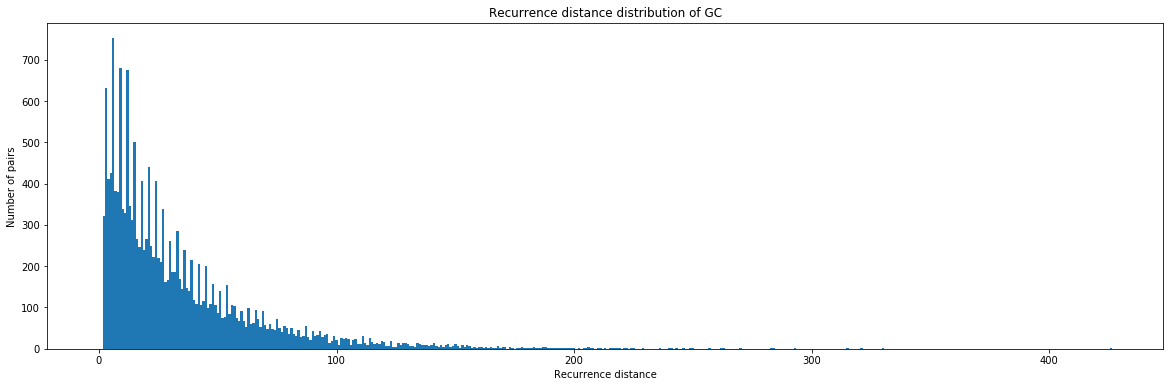

In [6]:
w = 'GC'
rdd = RDD(mg37,w)

def plot_RDD(rdd, title):
    """
        Plot an RDD distribution adding missing recurring distances, 
        between 1 and the original maximum distance,
        by adding a value of zero in correspondence of them.
    """
    # se a value equal to zero for the missing recurrence distances
    for d in range(0,max(rdd.keys())):
        rdd[d] = rdd.get(d,0) + 0
        
    # module can be imported by uring aliases to refer them
    import matplotlib.pyplot as plt 
    
    # set the figure size
    plt.rcParams['figure.figsize'] = [20, 6]
    # assign height of bars
    bar_values = [v for k,v in sorted(rdd.items())]
    # plot with specific values on the x-axis that are associated to the height
    plt.bar(sorted(rdd.keys()), bar_values, width=1.0)
    # set the label on the y-axis
    plt.ylabel('Number of pairs') 
    # set the label on the x-axis
    plt.xlabel('Recurrence distance')
    # set a title for the chart
    plt.title(title)
    # plot the chart
    plt.show()
    
plot_RDD(rdd, 'Recurrence distance distribution of '+ w)

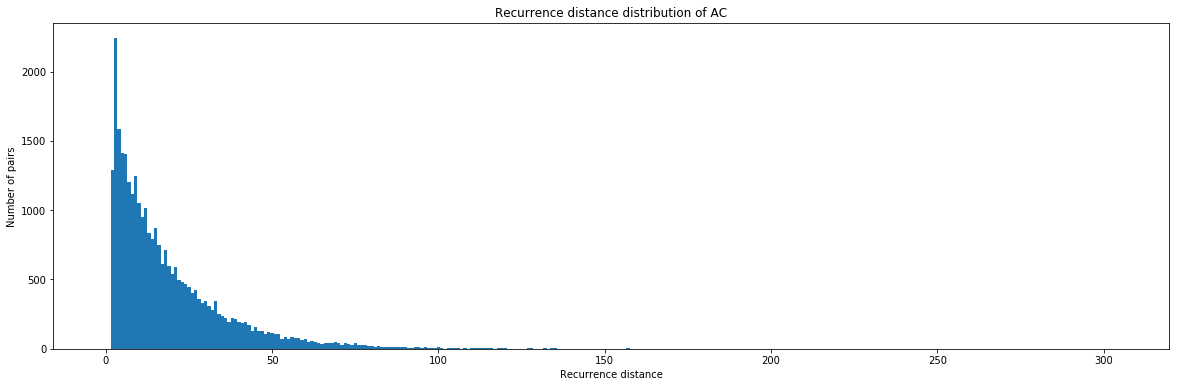

In [7]:
rdd = RDD(mg37,'AC')
plot_RDD(rdd, 'Recurrence distance distribution of AC')

---
## Average recurrence distance distribution
The average recurrence distribution (aRDD) reports an average value of recurrence regarding the RDDs of several words belonging to a dictionary. Usually, it is computed for the complete set of $k$-mers occurring in a string.

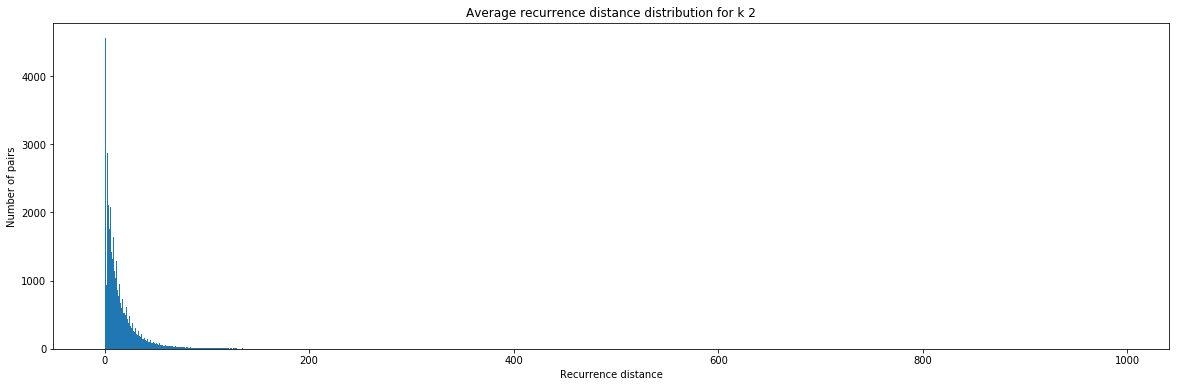

In [26]:
def aRDD(s,k):
    """
        Computer the average recurrence distance distribution of the complete set of k-mers occuring in s.
        ----
        Parameters:
            s (str) : the string from which extract the RDDs
            k (int) : the word length of the k-mers for which extract the RDD
        ----
        Returns:
            dict[int,float] : a dictionary mapping recurrence distances to the average number of times they occur
    """
    ardd = dict()
    kmers = get_kmers(s,k)
    for kmer in kmers:
        rdd = RDD(s,kmer)
        for distance,value in rdd.items():
            ardd[distance] = ardd.get(distance,0) + value
    for d,v in ardd.items():
        ardd[d] = ardd[d] / len(kmers)
    return ardd

k = 2
ardd = aRDD(mg37,k)

plot_RDD(ardd, 'Average recurrence distance distribution for k '+ str(k))

The following code shows the aRDD between the recurrence distances 1 and 60.

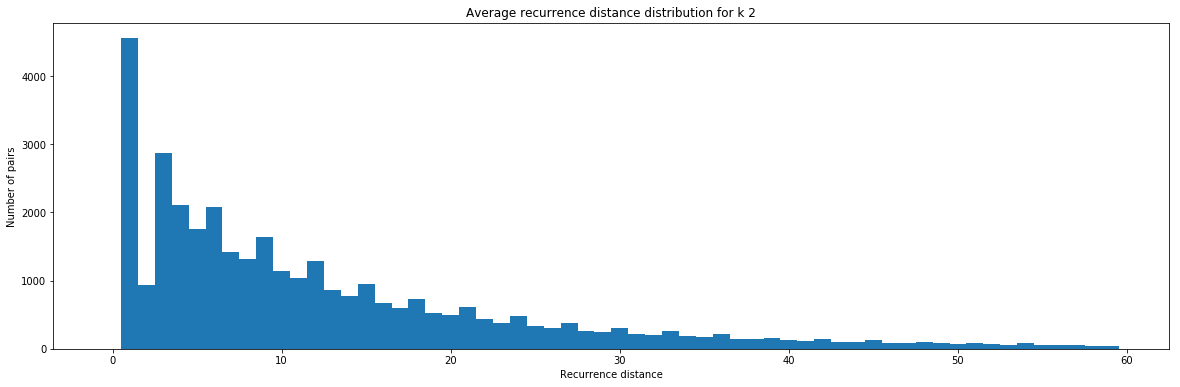

In [9]:
nardd = dict()
for d,v in ardd.items():
    if d <=  60:
        nardd[d] = v
ardd = nardd

plot_RDD(ardd, 'Average recurrence distance distribution for k '+ str(k))

---
## Reading GFF3 files
The GFF3 (general feature format, version 3) file format is sued to specify a list of annotations along a genome. An annotation is a contiguous region of the genomic sequences which show some particular properties. Common annotations are the genes. Each gene is identified by the starting and the ending coordinate, the strand and some supplementary non-physical descriptions.
<br>
GFF3 files are comma-separated values (CSV) files, which means that they are textual files in which a sort of column content is represented. Columns are separated with a specific character, usually a comma o a tabulation character. Additional comment lines are identified with an initial # character.
<br>
<br>
GFF3 have at least 6 tab-separated columns that are:
- 0 : annotation identifier
- 1 : source (database, organization, etc...)
- 2 :feature type (region, gene, exon, tRNA, etc...)
- 3 : start coordinate
- 4 : end coordinate
- 5 : score (gives an indication regarding the confidence of the sources)
- 6 : strand (+ or -)
- 7 : phase (phase o- CDS features)
- 8 : additional attributes

Independently from the strand, coordinates are given as absolute value from the first nuclueotide on the (+) 5'-3' strand.
<br>
<br>
The following code reads the GFF3 annotation file of the mycoplasma genitalium genome in order to extracts the parts of it that are covered by gene annotations. Since genes may reside on both strands and they also may overlap, thus the sequence coverage is intended as the number of position in the 5'-3' strand that are covered by at least one gene independently of the strand.
<br>
We also recall that GFF3 file usually only report annotation coordinates, thus the actual sequence must be retrieved from a corresponding FASTA file.

In [17]:
ifile = 'mycoplasma_genitalium_G37.fna'
mg37 = ''
for line in open(ifile, 'r'):
    if line.strip()[0] != '>':
        mg37 += line.strip()

coverage = [0 for i in range(len(mg37))]
        
ifile = 'mycoplasma_genitalium_G37.gff3'
for line in open(ifile, 'r'):
    if line[0] != "#":
        cc = line.split('\t')
        if len(cc) >= 6:
            if (cc[2] == 'gene'):# and (cc[6] == '+'): # we calculate the coverage of both strands as a single strand
                start = int(cc[3])
                end = int(cc[4])
                for i in range(start, end):
                    coverage[i] += 1

print('sequence coverage',   (len(coverage) - coverage.count(0)) / len(coverage))

# sequence of non-coding portion of the genome
ncseq = ''.join([ mg37[i] for i in range(len(mg37)) if coverage[i] == 0 ])

# sequence of coding portion of the genome
cseq = ''.join([ mg37[i] for i in range(len(mg37)) if coverage[i] > 0 ])

print('total length', len(mg37),', non-coding length',len(ncseq), ', protein-coding length', len(cseq))

sequence coverage 0.9502547941993807
total length 580076 , non-coding length 28856 , protein-coding length 551220


The sequence coverage indicates that 95% of the mycolpasma genitalium is covered by coding genes. This has crucial implications on the composition of the genome. In fact, it means that it is almost composed of nucleotides that codes for codons. Of course, the k-mer content is expected to be slight different from the non-coding portions. 
<br>
The following one is the multiplicity distribution of all the theoretical 2-mers computed on the non-coding part.

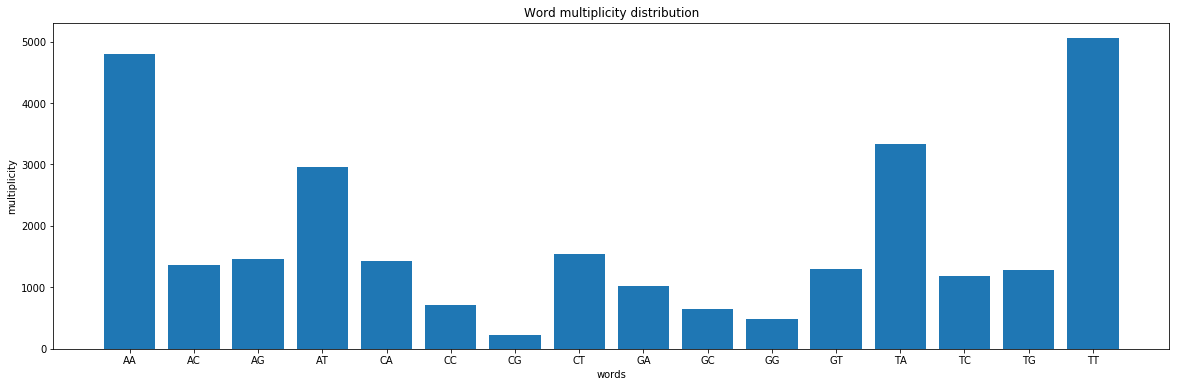

In [22]:
def list_words_2(prefix, k, nuc_alphabet, words):
    if len(prefix) == k:
        words.add(prefix)
    else:
        for a in nuc_alphabet:
            list_words_2(prefix + a, k, nuc_alphabet, words)
            
k = 2
kmers = set()
list_words_2('',k,['A','T','C','G'], kmers)
kmers = sorted(kmers)

ncseq_wmd = dict()
for kmer in kmers:
    ncseq_wmd[kmer] = count_occurrences(ncseq, kmer)

import matplotlib.pyplot as plt
bar_values = [v for k,v in sorted(ncseq_wmd.items())]
plt.rcParams['figure.figsize'] = [20, 6]
plt.bar(kmers, bar_values)
plt.xticks(kmers, kmers)
plt.ylabel('multiplicity')
plt.xlabel('words')
plt.title('Word multiplicity distribution')
plt.show()   

The following one is the multiplicity distribution of all the theoretical 2-mers computed on the coding part.

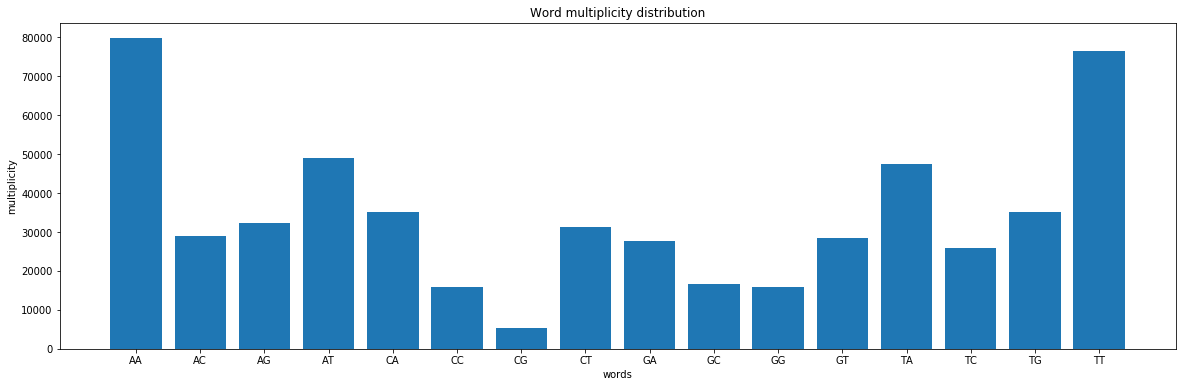

In [23]:
cseq_wmd = dict()
for kmer in kmers:
    cseq_wmd[kmer] = count_occurrences(cseq,kmer)
    
import matplotlib.pyplot as plt
bar_values = [v for k,v in sorted(cseq_wmd.items())]
plt.rcParams['figure.figsize'] = [20, 6]
plt.bar(kmers, bar_values)
plt.xticks(kmers, kmers)
plt.ylabel('multiplicity')
plt.xlabel('words')
plt.title('Word multiplicity distribution')
plt.show()   

There are differences between the two charts, however there is not a strong signal that indicate the presence of the coding language.
On the contrary, there is a strong evidence of the codon language via the analysis of the RDD composition. In the next sections, a crucial aspect of RDDs extracted from coding regions is shown to be distinctive of such parts w.r.t. to non-coding regions.

---
## Differences between coding and non-coding parts
the following chart is the average RDD calculate for the overall mycoplasma genitalium genome, as it has been shown before. The distribution seems to follow an exmponential distribution, as expected, but some distinctive peaks on recurrence distances multiple of 3 appear. Such peaks seem to follow an parallel exponential distribution.

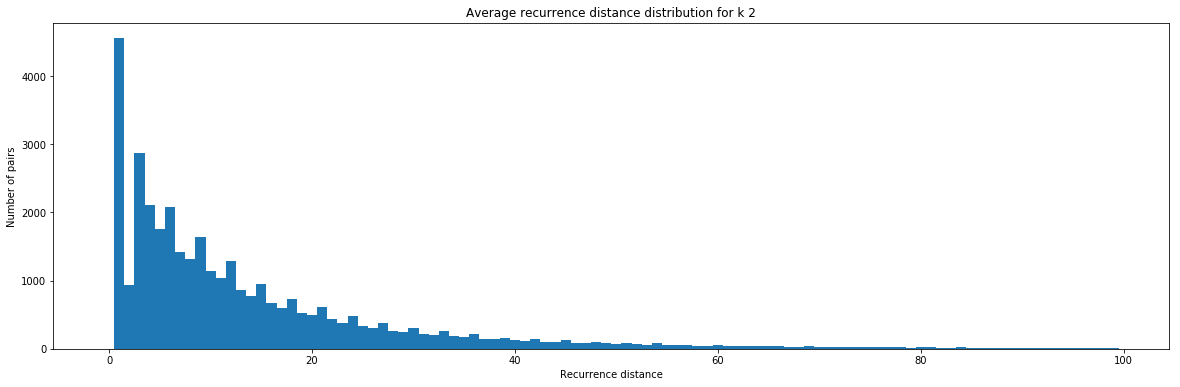

In [11]:
k = 2
ardd = aRDD(mg37,k)

nardd = dict()
for d,v in ardd.items():
    if d <  100:
        nardd[d] = v
ardd = nardd

plot_RDD(ardd, 'Average recurrence distance distribution for k '+ str(k))

<br>
The following char is the average RDD calculate over only the non-coding part of the genome. The parallel 3-peak distribution disappears.

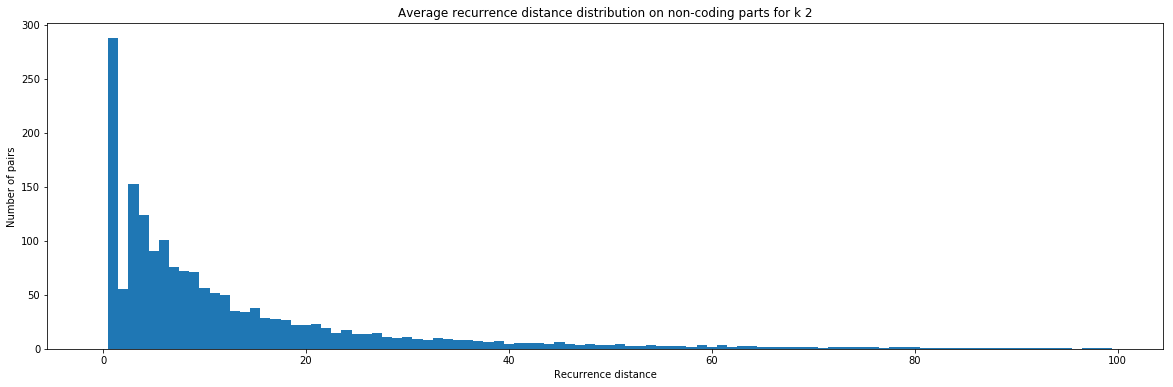

In [27]:
k = 2
ardd = aRDD(ncseq,k)

nardd = dict()
for d,v in ardd.items():
    if d < 100:
        nardd[d] = v
ardd = nardd

plot_RDD(ardd, 'Average recurrence distance distribution on non-coding parts for k '+ str(k))

<br>
When the average RDD is computed on only the coding part of the genome, the parallel 3-peak distribution appear back. 
The phenomenon is given by the 3-periodicity of the codon language that is reflected on the 3-peak distribution of the RDDs of almost all the 2-mers.
The implications on the overall sequence lead to the fact that the genome is almost covered by coding sequences

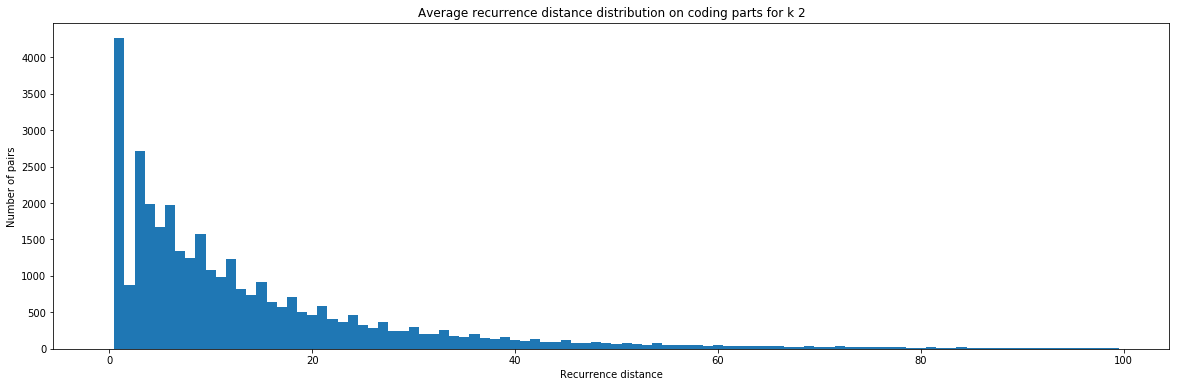

In [28]:
k = 2
ardd = aRDD(cseq,k)

nardd = dict()
for d,v in ardd.items():
    if d < 100:
        nardd[d] = v
ardd = nardd

plot_RDD(ardd, 'Average recurrence distance distribution on coding parts for k '+ str(k))